In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

In [2]:
claims_df = pd.read_csv('../data/processed/dim_claims_train.csv').fillna(0)
claims_df.loc[:, 'reject_code'] = claims_df['reject_code'].astype(int)
# only the rejected claims should be examined when determining reject code
claims_df = claims_df.loc[claims_df['pharmacy_claim_approved'] == 0]

claims_X = claims_df[['bin', 'drug']]
claims_y = claims_df['reject_code']

# Tasks
- Final Optimization of Hyperparameters
    - False positives have been determined to be worse than false negatives.
    - Reducing false positives can be performed by prioritizing recall.
    - It has been demonstrated that the minimum number of leaves can be achieved through three methods:
        1. (easiest) Setting `max_leaf_nodes` to the desired number of leaves.
        2. Increasing `ccp_alpha` or `min_impurity_decrease`.
- Test Split Model Evaluation

In [3]:
def build_pipe(ccp_alpha, min_impurity_decrease, max_leaf_nodes):
    encoder = OneHotEncoder(sparse=False, drop='first')
    model = DecisionTreeClassifier(random_state=42, 
                                   ccp_alpha=ccp_alpha, 
                                   min_impurity_decrease=min_impurity_decrease,
                                   max_leaf_nodes=max_leaf_nodes)
    pipe = Pipeline([('encoder', encoder),
                     ('model', model)])
    return pipe   

## Model without Constraints

In [4]:
ccp_alpha = 0
min_impurity_decrease = 0
max_leaf_nodes = 12

pipe = build_pipe(ccp_alpha, min_impurity_decrease, max_leaf_nodes)
pipe.fit(claims_X, claims_y)

Pipeline(steps=[('encoder', OneHotEncoder(drop='first', sparse=False)),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0, max_leaf_nodes=12,
                                        min_impurity_decrease=0,
                                        random_state=42))])

## Model with `max_leaf_node` Scan

In [5]:
fit_results = []

ccp_alpha = 0
min_impurity_decrease = 0

for max_leaf_nodes in range(5, 12):
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv.get_n_splits(claims_X)

    accuracy = []
    precision = []
    recall = []
    roc_auc = []
    n_leaves = []

    for train_index, test_index in cv.split(claims_X):
        X_train, X_test = claims_X.iloc[train_index], claims_X.iloc[test_index]
        y_train, y_test = claims_y.iloc[train_index], claims_y.iloc[test_index]

        pipe = build_pipe(ccp_alpha, min_impurity_decrease, max_leaf_nodes)
        pipe.fit(X_train, y_train)

        accuracy.append(accuracy_score(y_test, pipe.predict(X_test)))
        precision.append(precision_score(y_test, pipe.predict(X_test), average='macro'))
        recall.append(recall_score(y_test, pipe.predict(X_test), average='macro'))
        roc_auc.append(roc_auc_score(y_test, pipe.predict_proba(X_test), average='macro', multi_class='ovo'))
        n_leaves.append(pipe['model'].get_n_leaves())

    accuracy = np.mean(accuracy)
    recall = np.mean(recall)
    precision = np.mean(precision)
    roc_auc = np.mean(roc_auc)
    n_leaves = np.mean(n_leaves)

    fit_results.append({'ccp_alpha': ccp_alpha,
                        'min_impurity_decrease': min_impurity_decrease,
                        'max_leaves': max_leaf_nodes,
                        'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'roc_auc': roc_auc,
                        'n_leaves': n_leaves})
fit_results = pd.DataFrame(fit_results)

## Results with Maximum Recall

In [6]:
fit_results.loc[fit_results['recall'] == 1].sort_values('n_leaves')

,ccp_alpha,min_impurity_decrease,max_leaves,accuracy,precision,recall,roc_auc,n_leaves
5,0,0,10,1.0,1.0,1.0,1.0,10.0
6,0,0,11,1.0,1.0,1.0,1.0,10.0


## Scores vs. Number of Leaves

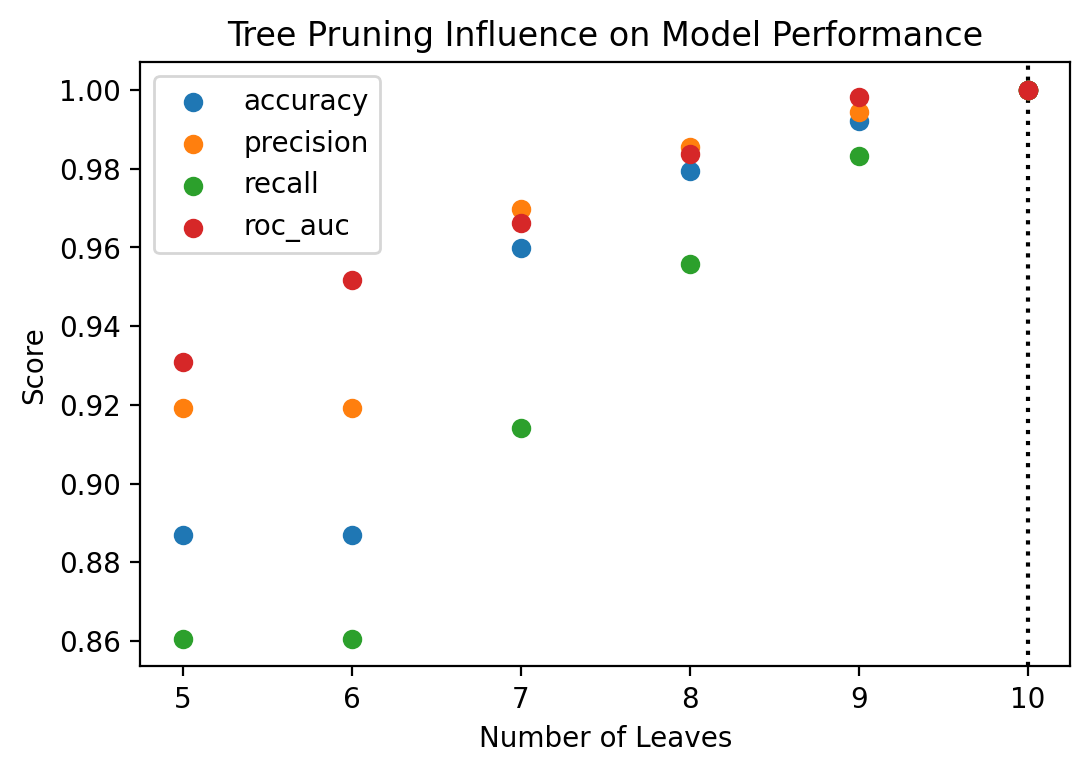

In [7]:
plt.figure(dpi=200)

x = fit_results['n_leaves']

for name, y in fit_results.drop(columns=['min_impurity_decrease', 'ccp_alpha', 'n_leaves', 'max_leaves']).iteritems():
    plt.scatter(x, y, label=name)

plt.title('Tree Pruning Influence on Model Performance')
plt.ylabel('Score')
plt.xlabel('Number of Leaves')
plt.axvline(10, color='k', ls=':', zorder=-1)
plt.legend()
plt.show()

In [8]:
final_pipe = build_pipe(0, 0, 10)
final_pipe.fit(claims_X, claims_y)

Pipeline(steps=[('encoder', OneHotEncoder(drop='first', sparse=False)),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0, max_leaf_nodes=10,
                                        min_impurity_decrease=0,
                                        random_state=42))])

In [9]:
claims_test_df = pd.read_csv('../data/processed/dim_claims_test.csv').fillna(0)
claims_test_df.loc[:, 'reject_code'] = claims_test_df['reject_code'].astype(int)
# only the rejected claims should be examined when determining reject code
claims_test_df = claims_test_df.loc[claims_test_df['pharmacy_claim_approved'] == 0]

claims_X_test = claims_test_df[['bin', 'drug']]
claims_y_test = claims_test_df['reject_code']

In [10]:
test_accuracy = accuracy_score(claims_y_test, final_pipe.predict(claims_X_test))
test_precision = precision_score(claims_y_test, final_pipe.predict(claims_X_test), average='macro')
test_recall = recall_score(claims_y_test, final_pipe.predict(claims_X_test), average='macro')
test_roc_auc = roc_auc_score(claims_y_test, final_pipe.predict_proba(claims_X_test), average='macro', multi_class='ovo')
test_n_leaves = final_pipe['model'].get_n_leaves()

print(f'Test Accuracy = {round(test_accuracy, 2)}')
print(f'Test Precision = {round(test_precision, 2)}')
print(f'Test Recall = {round(test_recall, 2)}')
print(f'Test ROC AUC = {round(test_roc_auc, 2)}')
print(f'Test # Leaves = {test_n_leaves}')

Test Accuracy = 1.0
Test Precision = 1.0
Test Recall = 1.0
Test ROC AUC = 1.0
Test # Leaves = 10
